# Model Selection

In [1]:
# data manipulation libraries
import pandas as pd

# custom project libraries
from utils.wine_review_utils import load_augmented_data, RATINGS
from utils.timer_utils import timeit

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Load Augmented Data

In [2]:
# focus on most reviewed variety from most reviewed country to accelerate the feature selection process
reviews = load_augmented_data()
pinot = reviews.query('variety == "Pinot Noir" and country == "US"') 
pinot.info()
pinot.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8886 entries, 4 to 129967
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   winery              8886 non-null   object 
 1   variety             8886 non-null   object 
 2   year                8886 non-null   int64  
 3   country             8886 non-null   object 
 4   price               8860 non-null   float64
 5   taster_name         8886 non-null   object 
 6   description         8886 non-null   object 
 7   points              8886 non-null   int64  
 8   rating              8886 non-null   object 
 9   description_length  8886 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 763.6+ KB


,winery,variety,year,country,price,taster_name,description,points,rating,description_length
4,Sweet Cheeks,Pinot Noir,2012,US,65.0,Paul Gregutt,"Much like the regular bottling from 2012, this...",87,very good,249
21,Acrobat,Pinot Noir,2013,US,20.0,Paul Gregutt,"A sleek mix of tart berry, stem and herb, alon...",87,very good,233
25,Castello di Amorosa,Pinot Noir,2011,US,69.0,Virginie Boone,Oak and earth intermingle around robust aromas...,87,very good,259
35,Erath,Pinot Noir,2010,US,50.0,Paul Gregutt,As with many of the Erath 2010 vineyard design...,86,good,242
78,Z'IVO,Pinot Noir,2015,US,25.0,Paul Gregutt,Some rosés are made simply by bleeding the jui...,86,good,288


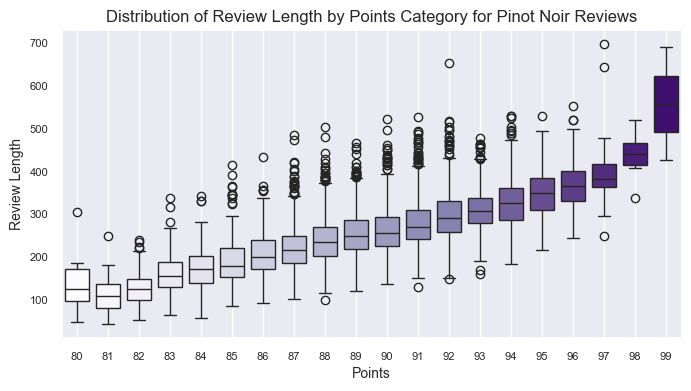

In [3]:
rating_order = ['acceptable', 'good', 'very good', 'excellent', 'superb', 'classic']
plt.figure(figsize=(8,4))
sns.boxplot(x = 'points', y = 'description_length', palette = 'Purples', hue='points', data = pinot, native_scale=False, legend=None)
plt.title("Distribution of Review Length by Points Category for Pinot Noir Reviews", fontsize=12)
plt.xlabel("Points",fontsize=10)
plt.ylabel("Review Length",fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

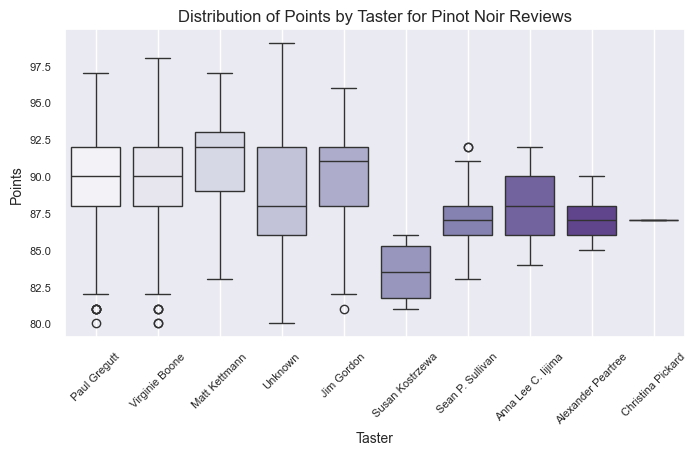

In [4]:
plt.figure(figsize=(8,4))
sns.boxplot(x = 'taster_name', y = 'points', palette = 'Purples', hue='taster_name', data = pinot, native_scale=False, legend=None)
plt.title("Distribution of Points by Taster for Pinot Noir Reviews", fontsize=12)
plt.xlabel("Taster",fontsize=10)
plt.ylabel("Points",fontsize=10)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=8)
plt.grid()
plt.show()

**Timing Helper**

In [5]:
# function to time the execution of a function
timings = []

## Model Selection

**Given** the training/test dataset below, determine which classifier to use.

### Training/Test Data Split

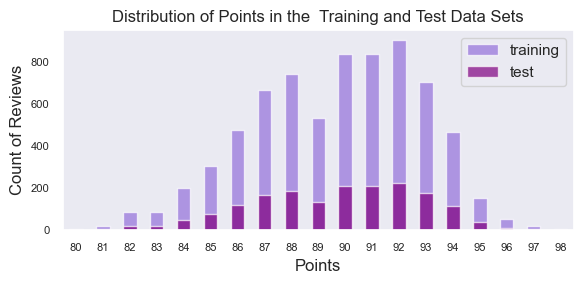

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# features
X = pinot[['variety', 'country', 'year', 'description_length', 'description']]
# target
le = LabelEncoder()
y = le.fit_transform(pinot.points)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# check the distribution of the target variable
fig = plt.figure(figsize=(6,3))
pd.Series(y_train).value_counts(normalize=False).sort_index().plot(kind='bar', color='mediumpurple', alpha=0.7, label='training')
pd.Series(y_test).value_counts(normalize=False).sort_index().plot(kind='bar', color='purple', alpha=0.7, label='test')
plt.title("Distribution of Points in the  Training and Test Data Sets")
plt.xlabel("Points")
plt.ylabel("Count of Reviews")
plt.xticks(plt.xticks()[0], labels=le.inverse_transform(plt.xticks()[0]), fontsize=8, rotation=0)
plt.yticks(fontsize=8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Feature Engineering

In [7]:
from sklearn.preprocessing import FunctionTransformer
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures

model = SentenceTransformer('all-mpnet-base-v2')
to_embeddings = lambda series: model.encode(series.to_list(), normalize_embeddings=False, show_progress_bar=True, device='mps')

to_features_out = lambda self, cols: [f'{i}' for i in range(768)]

transformer = ColumnTransformer([('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['variety', 'country']),
                                 ('scaler', Pipeline([('poly', PolynomialFeatures(degree=2)), ('scaler', MinMaxScaler())]), ['year', 'description_length']),
                                 ('embeds', Pipeline([('encode', FunctionTransformer(to_embeddings, feature_names_out=to_features_out)),
                                                      ('scaler', MinMaxScaler()),
                                                    ]), 'description'),
                                ])
transformer

ColumnTransformer(transformers=[('ohe',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['variety', 'country']),
                                ('scaler',
                                 Pipeline(steps=[('poly', PolynomialFeatures()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['year', 'description_length']),
                                ('embeds',
                                 Pipeline(steps=[('encode',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x3a8ab2ac0>,
                                                                      func=<function <lambda> at 0x3a8ab3c40>)),
                                                 ('scaler', MinMaxScaler())]),
                                 'description')])

In [8]:
X_train.head()

,variety,country,year,description_length,description
117646,Pinot Noir,US,2009,291,"This Pinot has an admirable delicacy, with fai..."
65227,Pinot Noir,US,2011,290,This bottling is curiously at odds with the wi...
84395,Pinot Noir,US,2007,175,"Rich flavors of cherries, red currants and lic..."
109928,Pinot Noir,US,2012,389,"As befits this ripe and forward vintage, this ..."
65961,Pinot Noir,US,2015,406,The nose on this bottling from the iconic vine...


In [9]:
# inspect the transformer
pd.DataFrame(transformer.fit_transform(X_train), columns=transformer.get_feature_names_out(), index=X_train.index).head()

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

,scaler__1,scaler__year,scaler__description_length,scaler__year^2,scaler__year description_length,scaler__description_length^2,embeds__0,embeds__1,embeds__2,embeds__3,...,embeds__758,embeds__759,embeds__760,embeds__761,embeds__762,embeds__763,embeds__764,embeds__765,embeds__766,embeds__767
117646,0.0,0.416667,0.379205,0.415941,0.379004,0.171155,0.339404,0.527719,0.519406,0.474151,...,0.207808,0.482249,0.524469,0.487453,0.550072,0.514840,0.479691,0.547927,0.676926,0.657930
65227,0.0,0.583333,0.377676,0.582608,0.377917,0.169954,0.562656,0.508355,0.539919,0.591471,...,0.237926,0.723456,0.274678,0.524613,0.588948,0.675193,0.539257,0.235068,0.680361,0.707518
84395,0.0,0.250000,0.201835,0.249440,0.201462,0.059459,0.422796,0.493749,0.403964,0.466702,...,0.410819,0.466257,0.642340,0.484201,0.623798,0.533863,0.497896,0.597968,0.476370,0.387403
109928,0.0,0.666667,0.529052,0.666003,0.529659,0.308852,0.606307,0.572353,0.649820,0.617821,...,0.345612,0.362249,0.582393,0.481394,0.245924,0.622616,0.287556,0.461726,0.632499,0.314962
65961,0.0,0.916667,0.555046,0.916439,0.556605,0.336778,0.490715,0.682861,0.276484,0.668397,...,0.345257,0.378527,0.445615,0.603316,0.345958,0.237392,0.496793,0.377797,0.737340,0.362185


**Note**: Since the data set is filtered to only include Pinot Noir varieties from the US, and the `ohe` is configured with `drop='first'`, there are no `ohe` features in the transformed feature matrix. Since we are only tyring to select the classifier we want to use for the fuller analysis, this is OK.

### Model Training

In [10]:
def create_pipeline(classifier):
    return Pipeline([('preprocessor', transformer),
                     ('classifier', classifier)])

**Determine Which Classifiers to use**

In [11]:
import warnings
import time

def evaluate_classifier(name, classifier, X_train,y_train, X_test,y_test, target):
  # define a simple classifier
  pipe = create_pipeline(classifier)
  
  # fit the classifier
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    start = time.perf_counter()
    pipe.fit(X_train, y_train)
    duration = time.perf_counter() - start
  return name, target, duration, pipe.score(X_train, y_train), pipe.score(X_test, y_test)

evaluate = lambda classifier, X_train,y_train, X_test,y_test, target='points': evaluate_classifier(classifier.__class__.__name__, classifier, X_train,y_train, X_test,y_test, target)


**The set of Classifiers to Evaluate**

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

classifiers = [
  # Logistic Regression
  LogisticRegression(max_iter=500, C=0.5, random_state=42, solver='newton-cholesky'),
  # Decision Tree Classifier
  DecisionTreeClassifier(max_depth=50, min_samples_split=5, random_state=42),
  # Multinomial Naive Bayes Classifier
  MultinomialNB(),
  # Support Vector Classifier
  SVC(random_state = 42, probability=True),
  # Gradient Boost Classifier
  GradientBoostingClassifier(random_state=42),
  # Ada Boost Classifier
  AdaBoostClassifier(random_state=42),
  # Random Forest Classifier
  RandomForestClassifier(max_depth=5, random_state=42),
  # Calibrated Classifier
  CalibratedClassifierCV(),
  # XGBClassifier
  XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, multi_strategy='one_output_per_tree'),
  # CatBoost Classifier
  CatBoostClassifier(verbose=False),
]

**Evaluate the Classifiers**

In [13]:
from tqdm import tqdm

results_points = pd.DataFrame([evaluate(classifier, X_train, y_train, X_test, y_test) for classifier in tqdm(classifiers)], columns=['classifier','target','duration','accuracy_train','accuracy_test'])
results_points

  0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 10%|█         | 1/10 [02:07<19:06, 127.42s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 20%|██        | 2/10 [02:32<08:58, 67.26s/it] 

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 30%|███       | 3/10 [02:52<05:19, 45.69s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 40%|████      | 4/10 [04:31<06:40, 66.73s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 50%|█████     | 5/10 [40:36<1:08:37, 823.50s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 60%|██████    | 6/10 [41:20<37:13, 558.46s/it]  

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 70%|███████   | 7/10 [41:45<19:11, 383.94s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 80%|████████  | 8/10 [43:22<09:45, 292.66s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [43:42<03:27, 207.41s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 10/10 [45:27<00:00, 272.71s/it]


,classifier,target,duration,accuracy_train,accuracy_test
0,LogisticRegression,points,115.667391,0.425295,0.215411
1,DecisionTreeClassifier,points,13.973304,0.895751,0.148481
2,MultinomialNB,points,8.796907,0.193585,0.173791
3,SVC,points,72.484498,0.582302,0.212036
4,GradientBoostingClassifier,points,2154.045285,0.792909,0.203600
5,AdaBoostClassifier,points,32.691334,0.171075,0.163105
6,RandomForestClassifier,points,13.528121,0.325549,0.196288
7,CalibratedClassifierCV,points,85.887552,0.487198,0.209224
8,XGBClassifier,points,8.894304,0.236916,0.182790
9,CatBoostClassifier,points,92.452354,0.999297,0.224972


**Repeat for Rating**

(8886,)
(7108,) (1778,)


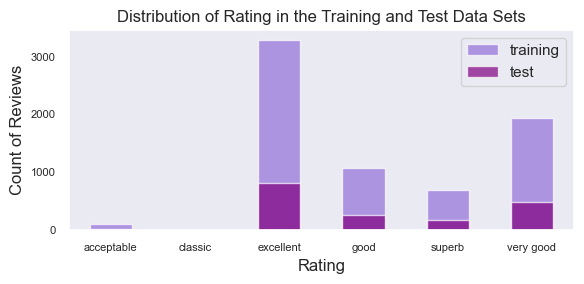

In [14]:
le = LabelEncoder()
y = le.fit_transform(pinot.rating)

print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

print(y_train.shape, y_test.shape)

# check the distribution of the target variable
fig = plt.figure(figsize=(6,3))
pd.Series(y_train).value_counts(normalize=False).sort_index().plot(kind='bar', color='mediumpurple', alpha=0.7, label='training')
pd.Series(y_test).value_counts(normalize=False).sort_index().plot(kind='bar', color='purple', alpha=0.7, label='test')
plt.title("Distribution of Rating in the Training and Test Data Sets")
plt.xlabel("Rating")
plt.ylabel("Count of Reviews")
plt.xticks([0,3,5,2,4,1], labels=le.inverse_transform([0,3,5,2,4,1]), fontsize=8, rotation=0)
plt.yticks(fontsize=8)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
results_rating = pd.DataFrame([evaluate(classifier, X_train,y_train, X_test,y_test, target='rating') for classifier in tqdm(classifiers)], columns=['classifier','target','duration','accuracy_train','accuracy_test'])
results_rating

  0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:28<04:17, 28.61s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:53<03:31, 26.41s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 30%|███       | 3/10 [01:13<02:44, 23.46s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 40%|████      | 4/10 [02:40<04:52, 48.75s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 50%|█████     | 5/10 [13:49<22:41, 272.40s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 60%|██████    | 6/10 [14:30<12:54, 193.68s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 70%|███████   | 7/10 [14:54<06:54, 138.10s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 80%|████████  | 8/10 [15:41<03:38, 109.27s/it]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [16:01<01:21, 81.20s/it] 

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/223 [00:00<?, ?it/s]

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 10/10 [16:48<00:00, 100.89s/it]


,classifier,target,duration,accuracy_train,accuracy_test
0,LogisticRegression,rating,17.223136,0.708216,0.622610
1,DecisionTreeClassifier,rating,13.849592,0.965532,0.465129
2,MultinomialNB,rating,8.675002,0.513225,0.517998
3,SVC,rating,62.662496,0.771384,0.625422
4,GradientBoostingClassifier,rating,658.029918,0.819218,0.600675
5,AdaBoostClassifier,rating,29.875459,0.514772,0.522497
6,RandomForestClassifier,rating,12.854014,0.592853,0.538245
7,CalibratedClassifierCV,rating,36.466747,0.701885,0.607424
8,XGBClassifier,rating,8.663700,0.574705,0.555681
9,CatBoostClassifier,rating,35.741366,0.999297,0.618110


**Combine the Results**

In [16]:
# combine results
results = pd.concat([results_points,results_rating], axis=0)
results

,classifier,target,duration,accuracy_train,accuracy_test
0,LogisticRegression,points,115.667391,0.425295,0.215411
1,DecisionTreeClassifier,points,13.973304,0.895751,0.148481
2,MultinomialNB,points,8.796907,0.193585,0.173791
3,SVC,points,72.484498,0.582302,0.212036
4,GradientBoostingClassifier,points,2154.045285,0.792909,0.203600
5,AdaBoostClassifier,points,32.691334,0.171075,0.163105
6,RandomForestClassifier,points,13.528121,0.325549,0.196288
7,CalibratedClassifierCV,points,85.887552,0.487198,0.209224
8,XGBClassifier,points,8.894304,0.236916,0.182790
9,CatBoostClassifier,points,92.452354,0.999297,0.224972


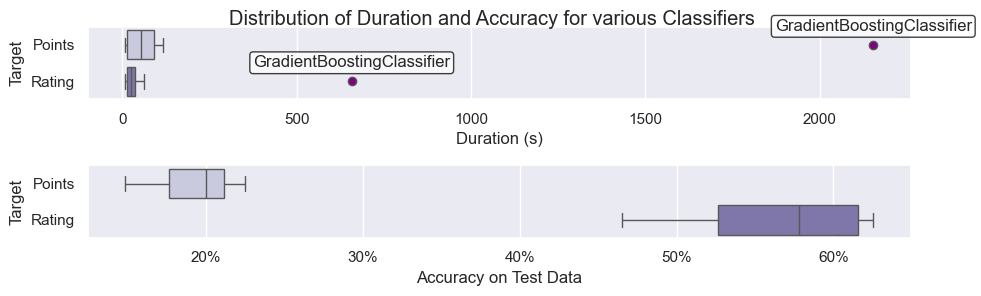

In [17]:
import warnings

fig, axes = plt.subplots(2, 1, figsize=(10,3))

ax = sns.boxplot(data = results, x='duration', y='target', hue='target', palette='Purples', ax=axes[0], flierprops={'markerfacecolor': 'purple'})
ax.set_xlabel('Duration (s)')
ax.set_ylabel('Target')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(['Points', 'Rating'])

# Iterate through fliers and add annotations
for i, flier in enumerate(ax.findobj(match=lambda x: type(x) == plt.Line2D and x.get_marker() == 'o')):
    x_data, y_data = flier.get_data()
    for x, y in zip(x_data, y_data):
        classifier=results.query(f'duration == {x}').classifier.values[0]
        ax.text(x, y-0.3, f'{classifier}', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.75, edgecolor='black', boxstyle='round,pad=0.2'))

ax = sns.boxplot(results, x='accuracy_test', y='target', ax=axes[1], hue='target', palette='Purples')
ax.set_xlabel('Accuracy on Test Data')
ax.set_ylabel('Target')
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(['Points', 'Rating'])
with warnings.catch_warnings():
  warnings.filterwarnings(action='ignore', category=UserWarning)
  ax.set_xticklabels([f'{float(v):.0%}' for v in ax.get_xticks()])

plt.tight_layout()
plt.suptitle('Distribution of Duration and Accuracy for various Classifiers')
plt.show()

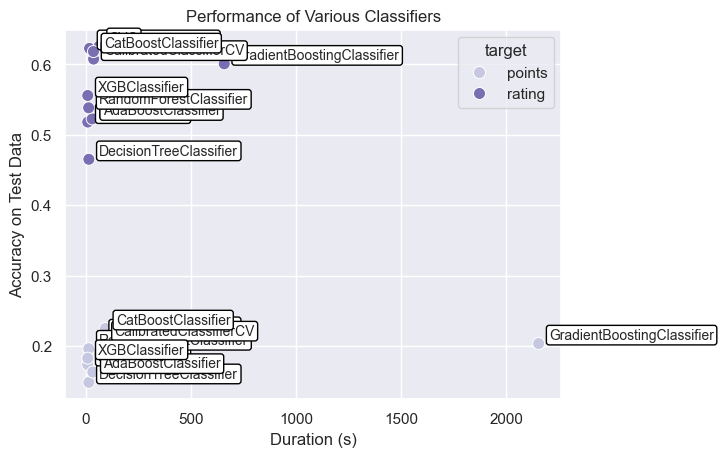

In [18]:
ax = sns.scatterplot(data=results, x='duration', y='accuracy_test', hue='target', palette='Purples', s=75)
# Annotate each point with its label
for i, row in results.iterrows():
    # ax.set_ylim(.0, .20)
    ax.text(row['duration']+50, row['accuracy_test']+.002, row['classifier'], fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'), 
            horizontalalignment='left', verticalalignment='bottom')
plt.title('Performance of Various Classifiers')
plt.xlabel('Duration (s)')
plt.ylabel('Accuracy on Test Data')
plt.show()

## Conclusion

Although not tuned, some classifiers show signs of overfitting like `LogisticRegression` and `DecisionTreeClassifier`, while othersm like `GradientBoostingClassifier` are computationally costly. $2$ specialized 3rd party classifiers were also evaluated, `XGBoost` and `CatBoost`. For this project, we will focus on the following three classifiers:
- traditional `MultinomialNB` classifier
- ensemble: `RandomForestClassifier`
- specialized 3rd party: `XGBoost`

## Next

- [Target Selection](target-selection.ipynb)